In [129]:
import pandas as pd
import numpy as np
import holidays
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
import xgboost as xgb
import shap

In [121]:
df = pd.read_csv("merged.csv", parse_dates=["DateTime"])

at_holidays = holidays.Austria()

df["target"] = df["Load_Actual"].shift(-1)

df["is_weekend"] = (df["DateTime"].dt.weekday >= 5).astype(int)
df["is_holiday"] = df["DateTime"].dt.date.map(at_holidays.__contains__).astype(int)
df["day_of_week"] = df["DateTime"].dt.weekday
df["week_of_year"] = df["DateTime"].dt.isocalendar().week.astype(int) - 1
df['is_workday'] = (~df['is_weekend'] & ~df['is_holiday']).astype(int)

seconds_in_day = 24 * 60 * 60
time_in_seconds = (
    df["DateTime"].dt.hour * 3600
    + df["DateTime"].dt.minute * 60
    + df["DateTime"].dt.second
)
df["time_sin"] = np.sin(2 * np.pi * time_in_seconds / seconds_in_day)
df["time_cos"] = np.cos(2 * np.pi * time_in_seconds / seconds_in_day)


dayahead_cols = df.filter(like="DayAhead").columns
df = df.drop(columns=dayahead_cols)

import pandas as pd

# Reihen VOR 1.10.2018 rauswerfen
cutoff = pd.Timestamp("2018-10-01")
df = df[df["DateTime"] >= cutoff]

# Am Ende so lange kürzen, bis keine NaNs mehr in der letzten Zeile stehen
full_rows = ~df.isna().any(axis=1)
last_full_idx = full_rows[full_rows].index[-1]

# Alles danach verwerfen
df = df.loc[:last_full_idx]

# Lags
df["load_lag_1"] = df["Load_Actual"].shift(1)
df["load_lag_2"] = df["Load_Actual"].shift(2)
df["load_lag_2"] = df["Load_Actual"].shift(3)
df["load_lag_4"] = df["Load_Actual"].shift(4)
df["load_lag_96"] = df["Load_Actual"].shift(96)
df["load_diff_1"] = df["load_lag_1"] - df["load_lag_2"]
df["load_diff_4"] = df["load_lag_1"] - df["load_lag_4"]
df["load_diff_24h"] = df["load_lag_1"] - df["load_lag_96"]


# Rolling-Statistiken
df["load_mean_1h"] = df["Load_Actual"].rolling(4).mean()
df["load_std_1h"]  = df["Load_Actual"].rolling(4).std()
df["load_ramp_1h"] = df["Load_Actual"].rolling(4).max() - df["Load_Actual"].rolling(4).min()

# Zyklischer Tag-im-Jahr (bereits diskutiert)
DOY   = df['DateTime'].dt.dayofyear
angle = 2 * np.pi * DOY / 365
df['doy_sin'] = np.sin(angle)
df['doy_cos'] = np.cos(angle)

# Nach dem Feature-Engineering: vordere NaNs entfernen
df = df.dropna().reset_index(drop=True)

In [122]:
# Frühestes und spätestes Datum bestimmen (für Wetterzeitraum)
start_date = df["DateTime"].min().date()
end_date = df["DateTime"].max().date()

# Beispiel: Koordinaten für Wien
latitude = 48.2082
longitude = 16.3738

# Wetterdaten abfragen
url = "https://archive-api.open-meteo.com/v1/archive"

params = {
    "latitude": latitude,
    "longitude": longitude,
    "start_date": start_date.isoformat(),
    "end_date": end_date.isoformat(),
    "hourly": "temperature_2m,shortwave_radiation,wind_speed_10m",
    "timezone": "auto"
}

response = requests.get(url, params=params)
data = response.json()

# Wetter-DataFrame
hourly_data = data.get("hourly", {})
weather = pd.DataFrame(hourly_data)

# Zeitspalte in datetime
if "time" in weather.columns:
    weather["time"] = pd.to_datetime(weather["time"])


In [123]:
# Stelle sicher, dass beide Zeitspalten datetime-formatiert und sortiert sind
df = df.sort_values("DateTime")
weather = weather.sort_values("time")

# Zeitlich passend mergen (left join: df ← weather)
df = pd.merge_asof(df, weather, left_on="DateTime", right_on="time", direction="backward")

# Optional: Wetter-Zeitspalte entfernen
df = df.drop(columns=["time"])


In [124]:
# Parameter für die Stärke der Krümmung
p = 1.2  # 1 = linear, >1 = stärkerer Anstieg bei Extremwerten

# Heizbedarf: stärkerer Anstieg unter 15 °C
df["heating_demand"] = df["temperature_2m"].apply(lambda t: (15 - t)**p if t < 15 else 0)

# Kühlbedarf: stärkerer Anstieg über 22 °C
df["cooling_demand"] = df["temperature_2m"].apply(lambda t: (t - 22)**p if t > 22 else 0)


In [125]:
df.head()

,DateTime,Actual_Solar,Actual_Wind Onshore,Load_Actual,target,is_weekend,is_holiday,day_of_week,week_of_year,is_workday,...,load_mean_1h,load_std_1h,load_ramp_1h,doy_sin,doy_cos,temperature_2m,shortwave_radiation,wind_speed_10m,heating_demand,cooling_demand
0,2018-10-02 00:00:00,0.0,570.0,5724.4,5720.8,0,0,1,39,-1,...,5750.1,50.207436,114.0,-0.999769,0.021516,10.2,0.0,19.6,6.568852,0.0
1,2018-10-02 00:15:00,0.0,580.0,5720.8,5674.8,0,0,1,39,-1,...,5725.0,16.788885,40.4,-0.999769,0.021516,10.2,0.0,19.6,6.568852,0.0
2,2018-10-02 00:30:00,0.0,624.0,5674.8,5670.8,0,0,1,39,-1,...,5706.8,22.582589,49.6,-0.999769,0.021516,10.2,0.0,19.6,6.568852,0.0
3,2018-10-02 00:45:00,0.0,632.0,5670.8,5708.0,0,0,1,39,-1,...,5697.7,28.835857,53.6,-0.999769,0.021516,10.2,0.0,19.6,6.568852,0.0
4,2018-10-02 01:00:00,0.0,660.0,5708.0,5613.6,0,0,1,39,-1,...,5693.6,24.633852,50.0,-0.999769,0.021516,10.1,0.0,19.7,6.733414,0.0


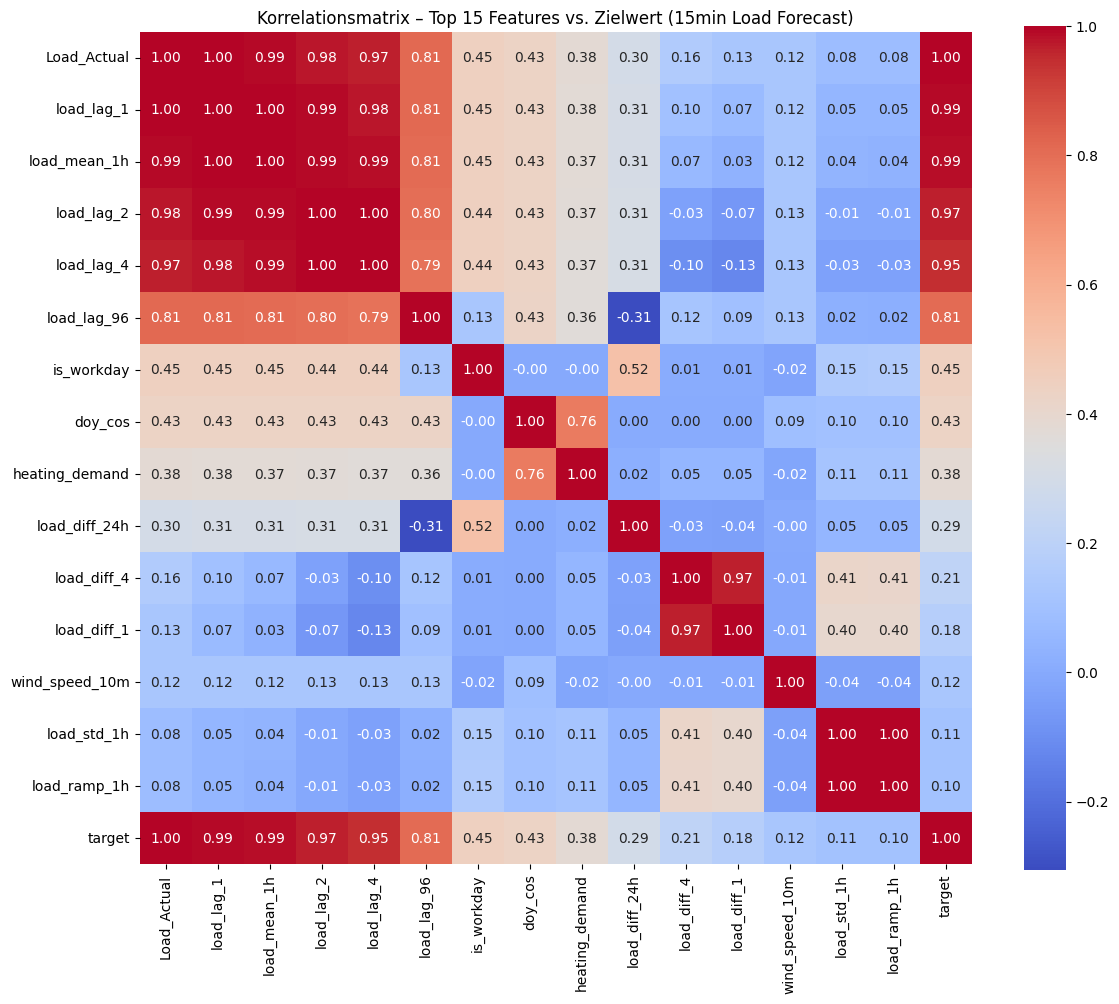

In [126]:
# Nur numerische Features
numeric_df = df.select_dtypes(include=["float64", "int64"])

# Korrelationsmatrix
corr_matrix = numeric_df.corr()

# Nur Korrelation mit dem Zielwert
target_corr = corr_matrix["target"].drop("target").sort_values(ascending=False)

# Heatmap (Top 15)
top_features = target_corr.head(15).index.tolist() + ["target"]

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix.loc[top_features, top_features], annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Korrelationsmatrix – Top 15 Features vs. Zielwert (15min Load Forecast)")
plt.tight_layout()
plt.show()


✅ RMSE  : 59.42
✅ MAE   : 45.08
✅ MAPE  : 0.68%


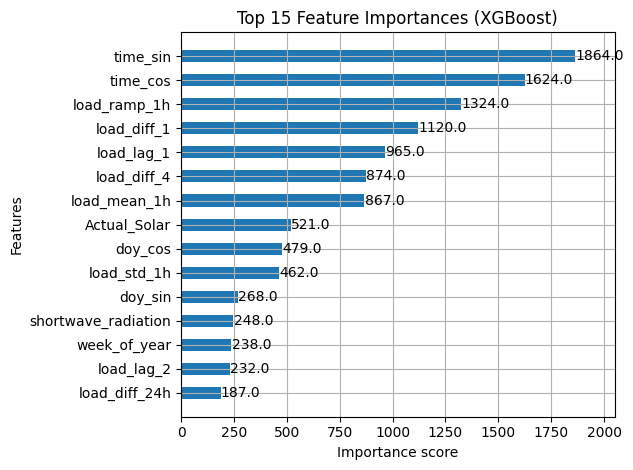

In [127]:
# Ziel: Verbrauch in 15 Minuten
df["target"] = df["Load_Actual"].shift(-1)

# Drop NaNs (durch Lags, Rolling, shift)
df = df.dropna().reset_index(drop=True)

# Exclude-Liste: nur die, die auch wirklich im DataFrame sind
exclude = [col for col in ["DateTime", "Load_Actual", "target"] if col in df.columns]

# Alle numerischen Features (float, int), außer target- und Info-Spalten
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
features = [col for col in numeric_cols if col not in exclude]

# Zeitlich sauberer Split (keine zufällige Mischung!)
split_index = int(len(df) * 0.8)
X_train = df.loc[:split_index, features]
y_train = df.loc[:split_index, "target"]
X_test  = df.loc[split_index+1:, features]
y_test  = df.loc[split_index+1:, "target"]

# XGBoost-Modell konfigurieren
model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Modell trainieren
model.fit(X_train, y_train)

# Vorhersage
y_pred = model.predict(X_test)

# Evaluation
rmse = mean_squared_error(y_test, y_pred) ** 0.5
mae  = mean_absolute_error(y_test, y_pred)
mape = (np.abs((y_test - y_pred) / y_test).mean()) * 100

print(f"✅ RMSE  : {rmse:.2f}")
print(f"✅ MAE   : {mae:.2f}")
print(f"✅ MAPE  : {mape:.2f}%")

# Feature Importance plotten
xgb.plot_importance(model, max_num_features=15, height=0.5)
plt.title("Top 15 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()



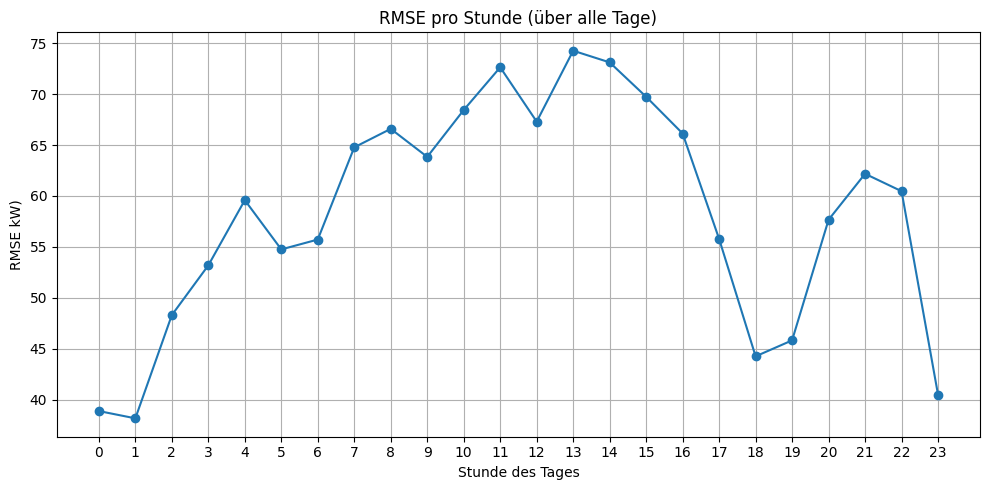

In [128]:
# Nach Modelltraining:
df_test = df.loc[split_index+1:].copy()
df_test = df_test.iloc[:len(y_pred)].copy()
df_test["y_pred"] = y_pred
df_test["error_squared"] = (df_test["target"] - df_test["y_pred"]) ** 2

# Stunde des Tages extrahieren
df_test["hour_of_day"] = df_test["DateTime"].dt.hour

# RMSE pro Stunde berechnen
rmse_by_hour = df_test.groupby("hour_of_day")["error_squared"].mean().apply(np.sqrt)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(rmse_by_hour.index, rmse_by_hour.values, marker="o")
plt.title("RMSE pro Stunde (über alle Tage)")
plt.xlabel("Stunde des Tages")
plt.ylabel("RMSE kW)")
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()


100%|===================| 46609/46618 [05:14<00:00]        

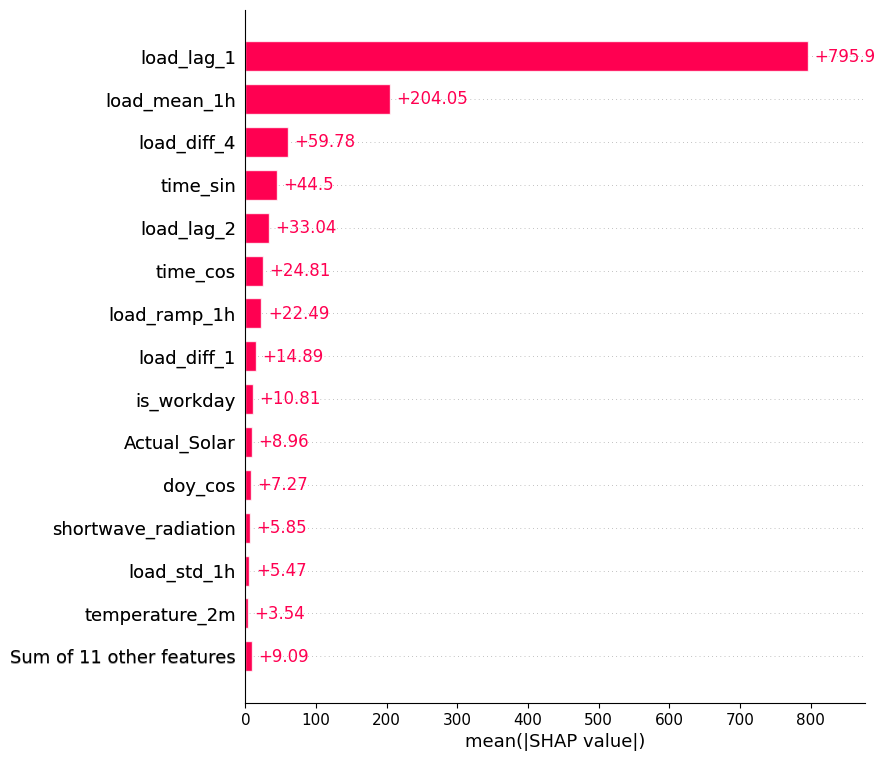

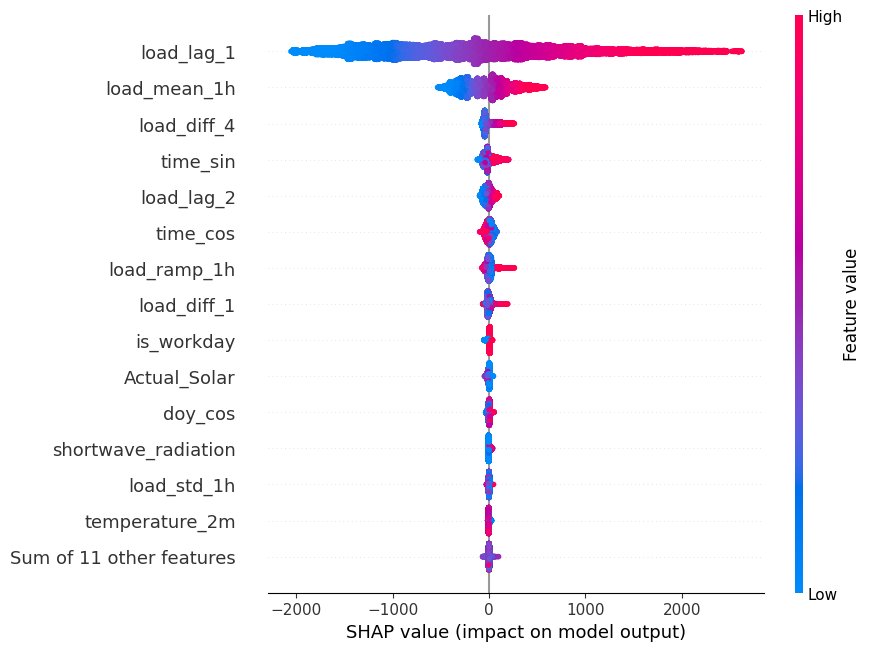

In [111]:
# 1. SHAP Explainer mit dem XGBoost-Modell erzeugen
explainer = shap.Explainer(model, X_train)

# 2. SHAP-Werte für Testdaten berechnen
shap_values = explainer(X_test)

# 3. Globale Feature-Wichtigkeit als Balkendiagramm
shap.plots.bar(shap_values, max_display=15)

# 4. Optional: SHAP Summary Plot (globaler Einfluss + Verteilung)
shap.plots.beeswarm(shap_values, max_display=15)


In [131]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "random_state": 42,
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=20, verbose=False)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    return rmse

# Optuna-Studie starten
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Beste Parameter anzeigen
print("✅ Beste Parameter:")
print(study.best_params)
print(f"🏆 RMSE: {study.best_value:.2f}")


[I 2025-05-30 18:45:52,710] A new study created in memory with name: no-name-9cc16819-f20d-4c64-80af-36cf0ddb06f0


  0%|          | 0/50 [00:00<?, ?it/s]

[W 2025-05-30 18:45:52,719] Trial 0 failed with parameters: {'n_estimators': 216, 'max_depth': 4, 'learning_rate': 0.02637166229960846, 'subsample': 0.7975852169739053, 'colsample_bytree': 0.8788333265073589, 'min_child_weight': 10} because of the following error: TypeError("XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'").
Traceback (most recent call last):
  File "C:\Users\Julia\miniconda3\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Julia\AppData\Local\Temp\ipykernel_14156\3823755746.py", line 13, in objective
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=20, verbose=False)
  File "C:\Users\Julia\miniconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'
[W 2025-05-30 

TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [137]:
# 1. Ziel-Funktion für Optuna (ohne early_stopping)
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "random_state": 42,
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    return rmse

# 2. Studie starten
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=500, show_progress_bar=True)

# 3. Beste Parameter anzeigen
print("\n✅ Beste Parameter:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")
print(f"\n🏆 Bestes RMSE (Testdaten): {study.best_value:.2f}")

# 4. Bestes Modell trainieren
best_model = xgb.XGBRegressor(**study.best_params)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# 5. Bewertung
rmse = mean_squared_error(y_test, y_pred) ** 0.5
mae  = mean_absolute_error(y_test, y_pred)
mape = (np.abs((y_test - y_pred) / y_test).mean()) * 100

print(f"\n📊 Modellbewertung (Testdaten):")
print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")
print(f"MAPE : {mape:.2f}%")

# 6. Feature-Wichtigkeit
xgb.plot_importance(best_model, max_num_features=15, height=0.5)
plt.title("Top 15 Feature Importances (Optimiertes XGBoost)")
plt.tight_layout()
plt.show()



[I 2025-05-30 19:28:00,527] A new study created in memory with name: no-name-ea3f92cb-8749-4eb6-ae44-9b43700861eb


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2025-05-30 19:28:08,032] Trial 0 finished with value: 62.58961406407237 and parameters: {'n_estimators': 876, 'max_depth': 5, 'learning_rate': 0.011526660231514364, 'subsample': 0.8497546059654857, 'colsample_bytree': 0.779341935292466, 'min_child_weight': 4}. Best is trial 0 with value: 62.58961406407237.
[I 2025-05-30 19:28:12,563] Trial 1 finished with value: 61.62752764267565 and parameters: {'n_estimators': 494, 'max_depth': 8, 'learning_rate': 0.24261898093849, 'subsample': 0.4155988669543663, 'colsample_bytree': 0.347856887880455, 'min_child_weight': 4}. Best is trial 1 with value: 61.62752764267565.
[I 2025-05-30 19:28:14,721] Trial 2 finished with value: 58.15608247861958 and parameters: {'n_estimators': 419, 'max_depth': 4, 'learning_rate': 0.25608176371351316, 'subsample': 0.38964898449048313, 'colsample_bytree': 0.7372940493757301, 'min_child_weight': 10}. Best is trial 2 with value: 58.15608247861958.
[I 2025-05-30 19:28:17,407] Trial 3 finished with value: 62.525351922

KeyboardInterrupt: 